In [2]:
pip install --upgrade xgboost shap

In [3]:
pip install scikit-multilearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.4/89.4 kB 3.7 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import shap
from xgboost import XGBClassifier
from skmultilearn.problem_transform import LabelPowerset
from sklearn.model_selection import train_test_split
from sklearn.metrics import (classification_report, recall_score, hamming_loss, jaccard_score,
                             multilabel_confusion_matrix, f1_score, precision_score, accuracy_score,
                             zero_one_loss)
from datetime import datetime

# Record start time
st = datetime.now()

# Load the dataset
file_path = 'Tactic_Dataset.csv'
df = pd.read_csv(file_path)

# Drop the column 'Lateral Movement' from the DataFrame
df = df.drop(columns=['Lateral Movement'])

# Assume the last n_labels columns are the labels
n_labels = 11  # replace with the actual number of label columns

# Separate features and labels
X = df.iloc[:, 1:-n_labels]
y = df.iloc[:, -n_labels:]


In [5]:
from sklearn.neighbors import NearestNeighbors
import random
import numpy as np

def get_tail_label(df):
    """
    Give tail label colums of the given target dataframe

    args
    df: pandas.DataFrame, target label df whose tail label has to identified

    return
    tail_label: list, a list containing column name of all the tail label
    """
    columns = df.columns
    n = len(columns)
    irpl = np.zeros(n)
    for column in range(n):
        irpl[column] = df[columns[column]].value_counts()[1]
    irpl = max(irpl)/irpl
    mir = np.average(irpl)
    tail_label = []
    for i in range(n):
        if irpl[i] > mir:
            tail_label.append(columns[i])
    print(tail_label)
    return tail_label

def get_index(df):
  """
  give the index of all tail_label rows
  args
  df: pandas.DataFrame, target label df from which index for tail label has to identified

  return
  index: list, a list containing index number of all the tail label
  """
  tail_labels = get_tail_label(df)
  index = set()
  for tail_label in tail_labels:
    sub_index = set(df[df[tail_label]==1].index)
    index = index.union(sub_index)
  return list(index)

def get_minority_instace(X, y):
    """
    Give minority dataframe containing all the tail labels

    args
    X: pandas.DataFrame, the feature vector dataframe
    y: pandas.DataFrame, the target vector dataframe

    return
    X_sub: pandas.DataFrame, the feature vector minority dataframe
    y_sub: pandas.DataFrame, the target vector minority dataframe
    """
    index = get_index(y)
    X_sub = X[X.index.isin(index)].reset_index(drop = True)
    y_sub = y[y.index.isin(index)].reset_index(drop = True)
    return X_sub, y_sub

def nearest_neighbour(X):
    """
    Give index of 5 nearest neighbor of all the instance

    args
    X: np.array, array whose nearest neighbor has to find

    return
    indices: list of list, index of 5 NN of each element in X
    """
    nbs=NearestNeighbors(n_neighbors=5,metric='euclidean',algorithm='kd_tree').fit(X)
    euclidean,indices= nbs.kneighbors(X)
    return indices

def MLSMOTE(X,y, n_sample):
    """
    Give the augmented data using MLSMOTE algorithm

    args
    X: pandas.DataFrame, input vector DataFrame
    y: pandas.DataFrame, feature vector dataframe
    n_sample: int, number of newly generated sample

    return
    new_X: pandas.DataFrame, augmented feature vector data
    target: pandas.DataFrame, augmented target vector data
    """
    indices2 = nearest_neighbour(X)
    n = len(indices2)
    new_X = np.zeros((n_sample, X.shape[1]))
    target = np.zeros((n_sample, y.shape[1]))
    for i in range(n_sample):
        reference = random.randint(0,n-1)
        neighbour = random.choice(indices2[reference,1:])
        all_point = indices2[reference]
        nn_df = y[y.index.isin(all_point)]
        ser = nn_df.sum(axis = 0, skipna = True)
        target[i] = np.array([1 if val>2 else 0 for val in ser])
        ratio = random.random()
        gap = X.loc[reference,:] - X.loc[neighbour,:]
        new_X[i] = np.array(X.loc[reference,:] + ratio * gap)
    new_X = pd.DataFrame(new_X, columns=X.columns)
    target = pd.DataFrame(target, columns=y.columns)
    new_X = pd.concat([X, new_X], axis=0)
    target = pd.concat([y, target], axis=0)
    return new_X, target

In [6]:
# Get the minority instance data
X_sub, y_sub = get_minority_instace(X, y)

['Initial Access', 'Exfiltration']


In [7]:
def calculate_n_sample(y, target_percentage=100, max_samples=None):
    """
    Calculate the required number of synthetic samples to achieve a target
    percentage of the highest label count without exceeding the original sample count.

    Args:
    y (pd.DataFrame): The target vector dataframe with binary multi-label columns.
    target_percentage (int): Target percentage of the maximum label count
                             for balancing (e.g., 25, 50, 75, or 100).
    max_samples (int): Maximum allowable samples to generate (e.g., original dataset size).

    Returns:
    int: Total number of synthetic samples needed, capped at max_samples.
    """
    # Find the count of the most common label
    label_counts = y.sum(axis=0)
    max_count = label_counts.max()

    # Calculate the target count based on the specified percentage
    target_count = int(max_count * (target_percentage / 100))


    return target_count

In [ ]:
# Open the file and read the contents
with open('Tactic_Best_300.txt', 'r') as file:
    # Read the content and split by commas
    features = file.read().split(',')

# Strip any leading or trailing whitespace from each item in the list
features = [feature.strip() for feature in features]

# Print the list
print(features)


['com.ytj.openapkplugin.keeporstartmaservice', 'android.permission.read_sms', 'com.snaptube.premiumplus.activity.contentlocationactivity', 'me.everything.badger.permission.badge_count_write', 'com.facebook.unity.fbunitygamerequestactivity', 'com.xbot.core.adminactivity', 'com.pay.google.service.payreceiver', 'com.inka.appsealing.appsealingservice', 'org.wollyrolly.core.runservice', 'com.snaptube.premiumplus.activity.videoplayerfullscreenactivity', 'com.google.android.gms.ads.adactivity', 'android.permission.system_overlay_window', 'com.vivointernetgratis.permissions$requestactivity', 'sun.photoalbum1.sunservice.sun4.llll1', 'android.permission.clear_app_cache', 'android.permission.change_network_state', 'com.receivers.touchreceiver', 'android.permission.access_background_location', 'com.abbondioendrizzi.antivirus.supercleaner.screen.gameboost.gameboostactivity', 'com.huawei.lucky_money.receiver.mydeviceadminreceiver', 'com.gamtertainment.worldwar2.stickman.battle.simulator.ww2.warriors

In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import train_test_split
from sklearn.metrics import (classification_report, recall_score, hamming_loss, jaccard_score,
                             multilabel_confusion_matrix, f1_score, precision_score, accuracy_score,
                             zero_one_loss)
from xgboost import XGBClassifier
from skmultilearn.problem_transform import LabelPowerset
from functools import reduce
import time

# Store execution times for each value of k
execution_data = []

# Get column names for X
column_names = df.columns[1:-11].tolist()
label_names = y.columns.tolist()

# Function to evaluate the model
def evaluate_model(X_test_selected, y_test, model_name):

    lb_predictions = lb_model.predict(X_test_selected)

    print(f"Evaluating {model_name}")
    print(f"Accuracy: {accuracy_score(y_test, lb_predictions)}")
    print(f"Macro F1 Score: {f1_score(y_test, lb_predictions, average='macro')}")
    print(f"Weighted F1 score: {f1_score(y_test, lb_predictions, average='weighted')}")
    print(f"Micro F1 score: {f1_score(y_test, lb_predictions, average='micro')}")
    print(f"Macro Precision: {precision_score(y_test, lb_predictions, average='macro')}")
    print(f"Weighted Precision: {precision_score(y_test, lb_predictions, average='weighted')}")
    print(f"Micro Precision: {precision_score(y_test, lb_predictions, average='micro')}")
    print(f"Macro Recall: {recall_score(y_test, lb_predictions, average='macro')}")
    print(f"Weighted Recall: {recall_score(y_test, lb_predictions, average='weighted')}")
    print(f"Micro Recall: {recall_score(y_test, lb_predictions, average='micro')}")
    print(f"Hamming Loss: {hamming_loss(y_test, lb_predictions)}")
    print(f"Zero One Loss: {zero_one_loss(y_test, lb_predictions)}")
    print(f"Jaccard Similarity: {jaccard_score(y_test, lb_predictions, average='samples')}")
    print(f"Classification Report:\n{classification_report(y_test, lb_predictions, target_names=label_names)}")
    print(f"Multilabel Confusion Matrix:\n{multilabel_confusion_matrix(y_test, lb_predictions)}")
    print("\n")


original_sample_count = len(y)
percentage =100

n_sample = calculate_n_sample(y, target_percentage=percentage, max_samples=original_sample_count)

# Apply MLSMOTE to generate augmented data
X_res, y_res = MLSMOTE(X_sub, y_sub, n_sample)

X_aug=pd.concat([X, X_res], axis=0)
y_aug=pd.concat([y, y_res], axis=0)

X_train, X_test, y_train, y_test = train_test_split(X_aug, y_aug, test_size=0.2, random_state=42)
X_train_selected = X_train.loc[:, features]
X_test_selected = X_test.loc[:, features]

# Convert selected features to NumPy arrays
X_train_selected = X_train_selected.values  # Convert to NumPy array
X_test_selected = X_test_selected.values    # Convert to NumPy array

lb_model = LabelPowerset(XGBClassifier(gamma=0,learning_rate=0.3,max_depth=6,n_estimators=100,random_state=42))
lb_model.fit(X_train_selected, y_train)
evaluate_model(X_test_selected, y_test, "Label Powerset")





Evaluating Label Powerset
Accuracy: 0.9822429906542056
Macro F1 Score: 0.9926860738435699
Weighted F1 score: 0.9952934977617628
Micro F1 score: 0.9952963311382879
Macro Precision: 0.9940781315350592
Weighted Precision: 0.9953942337521058
Micro Precision: 0.9953814574067739
Macro Recall: 0.9913405238685887
Weighted Recall: 0.9952112194287669
Micro Recall: 0.9952112194287669
Hamming Loss: 0.004672897196261682
Zero One Loss: 0.017757009345794383
Jaccard Similarity: 0.9913169411066609
Classification Report:
                      precision    recall  f1-score   support

   Credential Access       0.98      0.99      0.98       303
     Defence Evasion       1.00      1.00      1.00       947
           Discovery       1.00      1.00      1.00       960
           Execution       1.00      0.99      1.00       600
      Initial Access       0.99      0.96      0.98       111
         Persistance       1.00      0.99      1.00       331
        Exfiltration       1.00      1.00      1.00     

# SHAP Explanation

In [10]:
import shap

# Extract the base classifier from LabelPowerset
base_model = lb_model.classifier

# Create a SHAP explainer with the base model
explainer = shap.Explainer(base_model, X_train_selected)





In [ ]:
# Calculate SHAP values
shap_values = explainer(X_test_selected)

In [ ]:
import pickle

# Save the SHAP values to a file using pickle
with open('tactic_shap_values.pkl', 'wb') as f:
    pickle.dump(shap_values, f)


In [ ]:
import pickle
import shap
# Load the SHAP values from the pickle file
with open('tactic_shap_values.pkl', 'rb') as f:
    shap_values = pickle.load(f)

SHAP summary plot for label Credential Access


/usr/local/lib/python3.10/dist-packages/shap/plots/_beeswarm.py:950: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  pl.tight_layout()


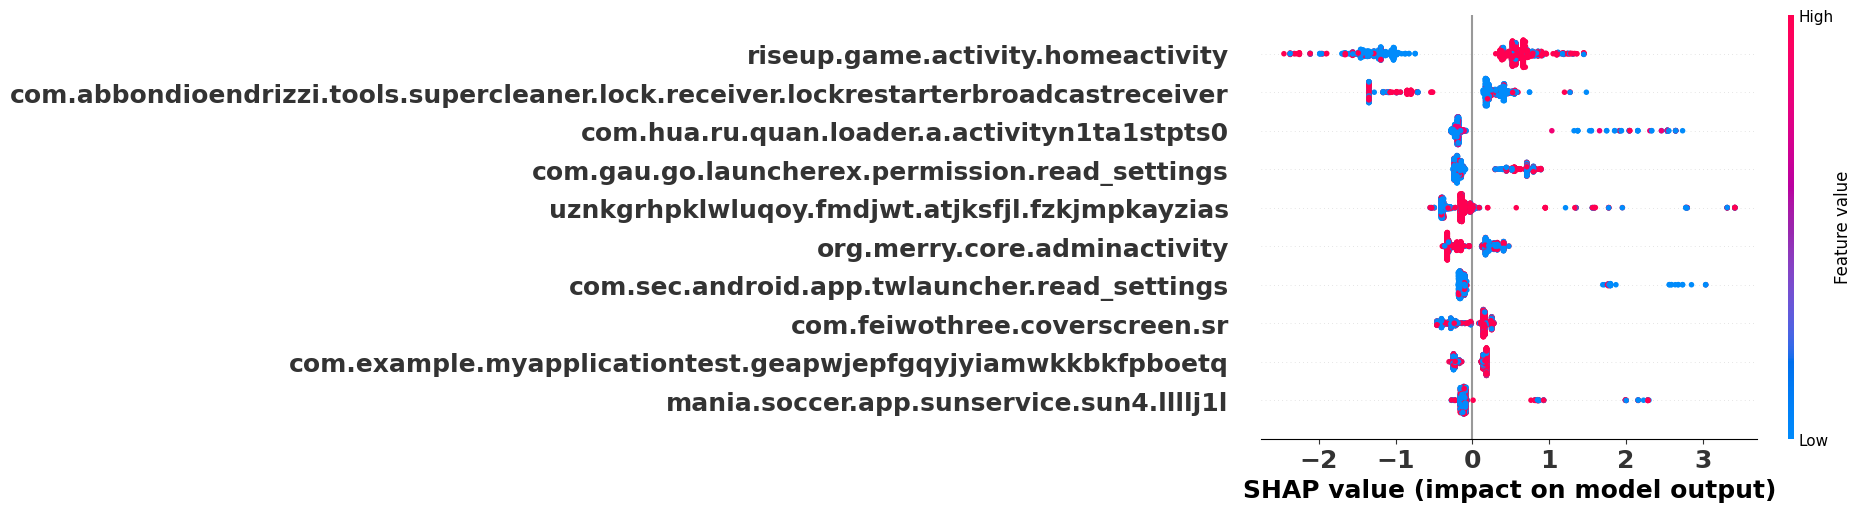

SHAP summary plot for label Defence Evasion


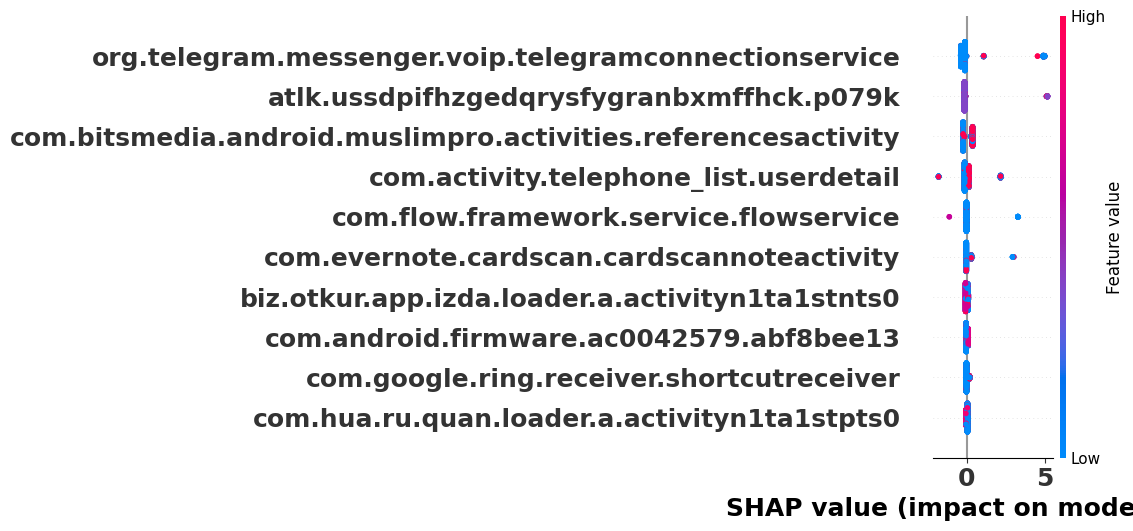

SHAP summary plot for label Discovery


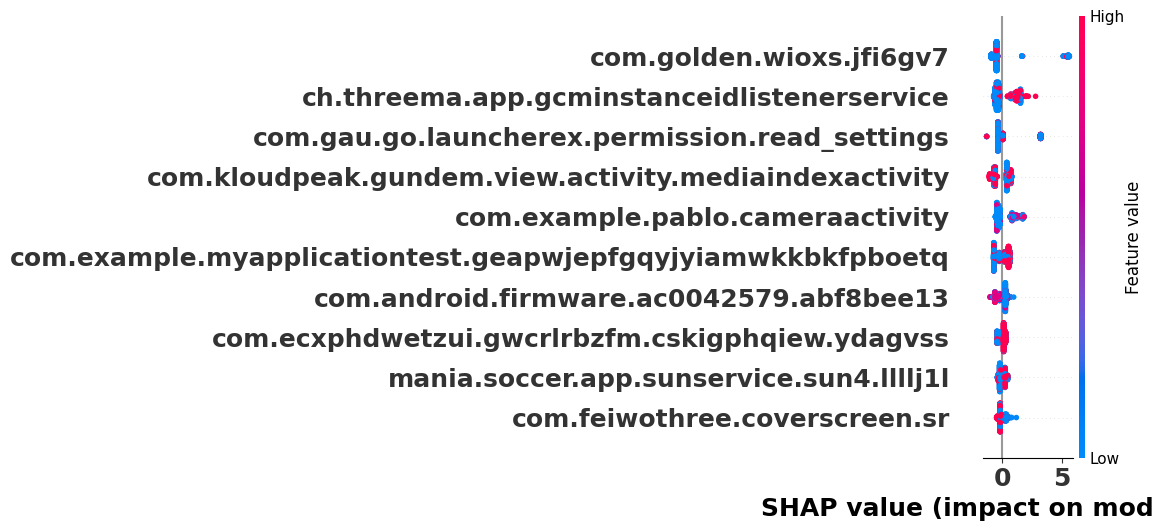

SHAP summary plot for label Execution


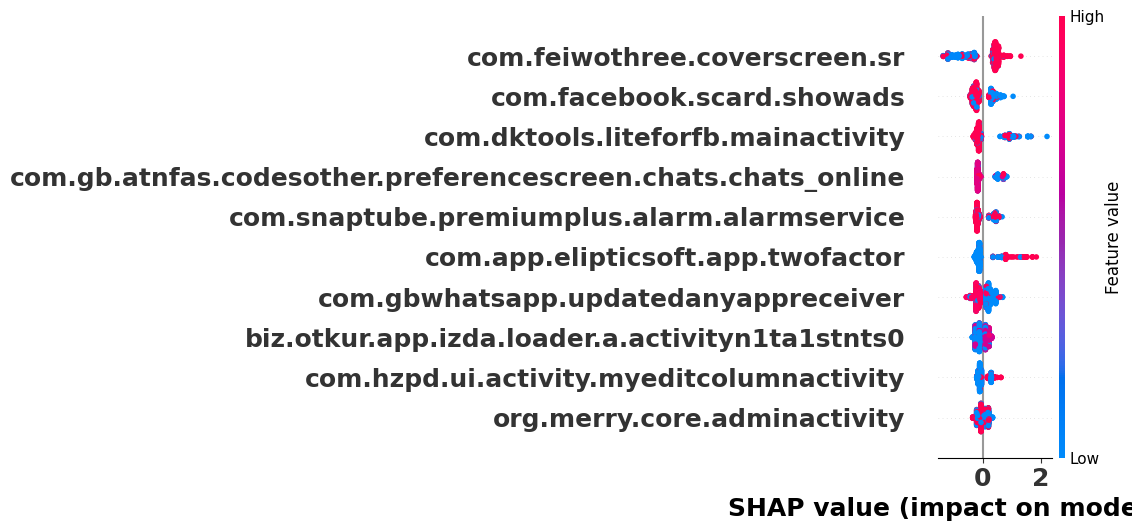

SHAP summary plot for label Initial Access


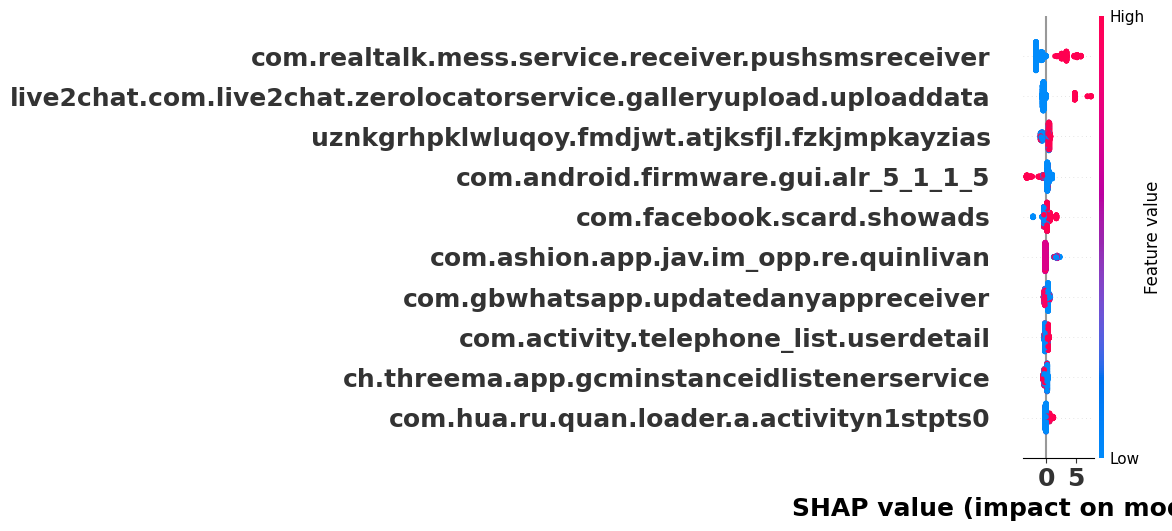

SHAP summary plot for label Persistance


/usr/local/lib/python3.10/dist-packages/shap/plots/_beeswarm.py:950: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  pl.tight_layout()


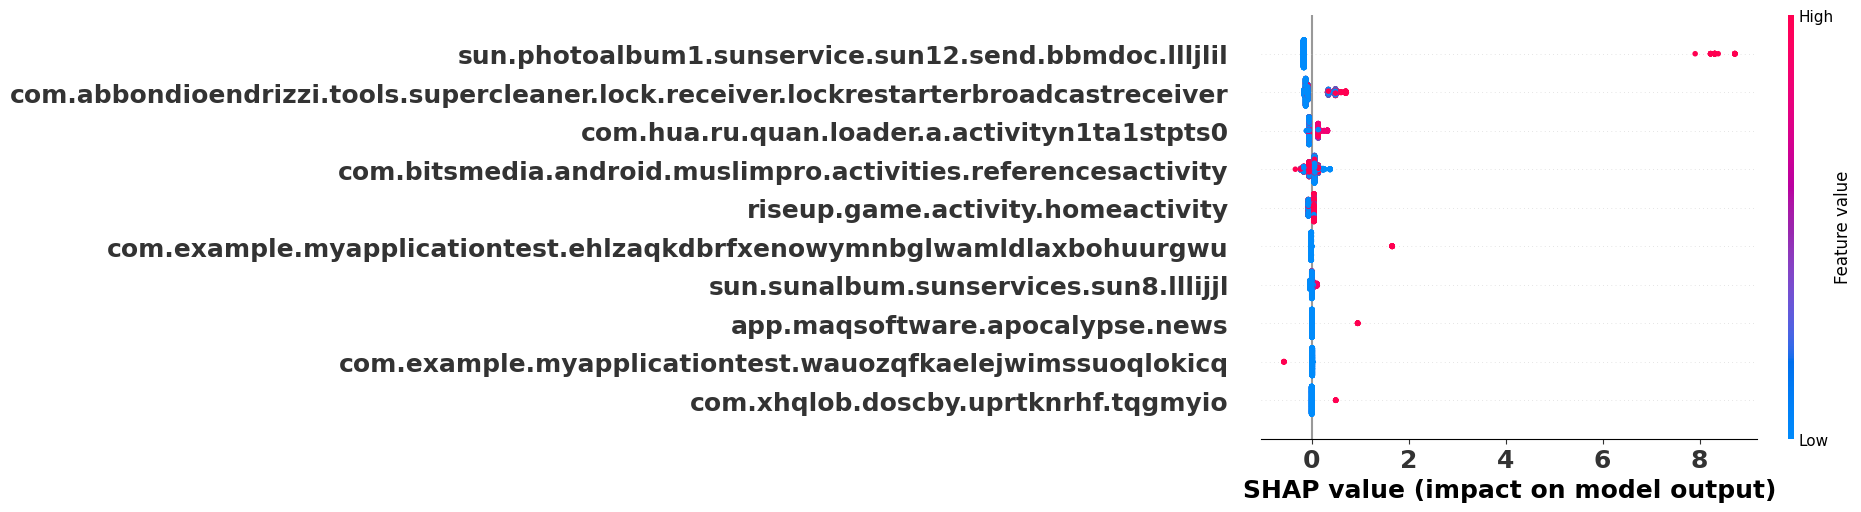

SHAP summary plot for label Exfiltration


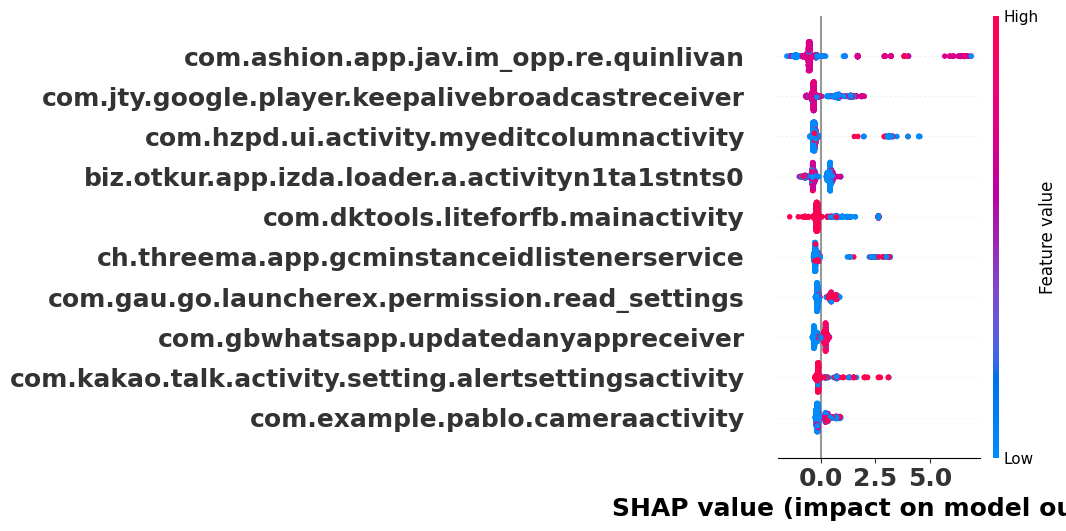

SHAP summary plot for label Privilage Escalation


/usr/local/lib/python3.10/dist-packages/shap/plots/_beeswarm.py:950: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  pl.tight_layout()


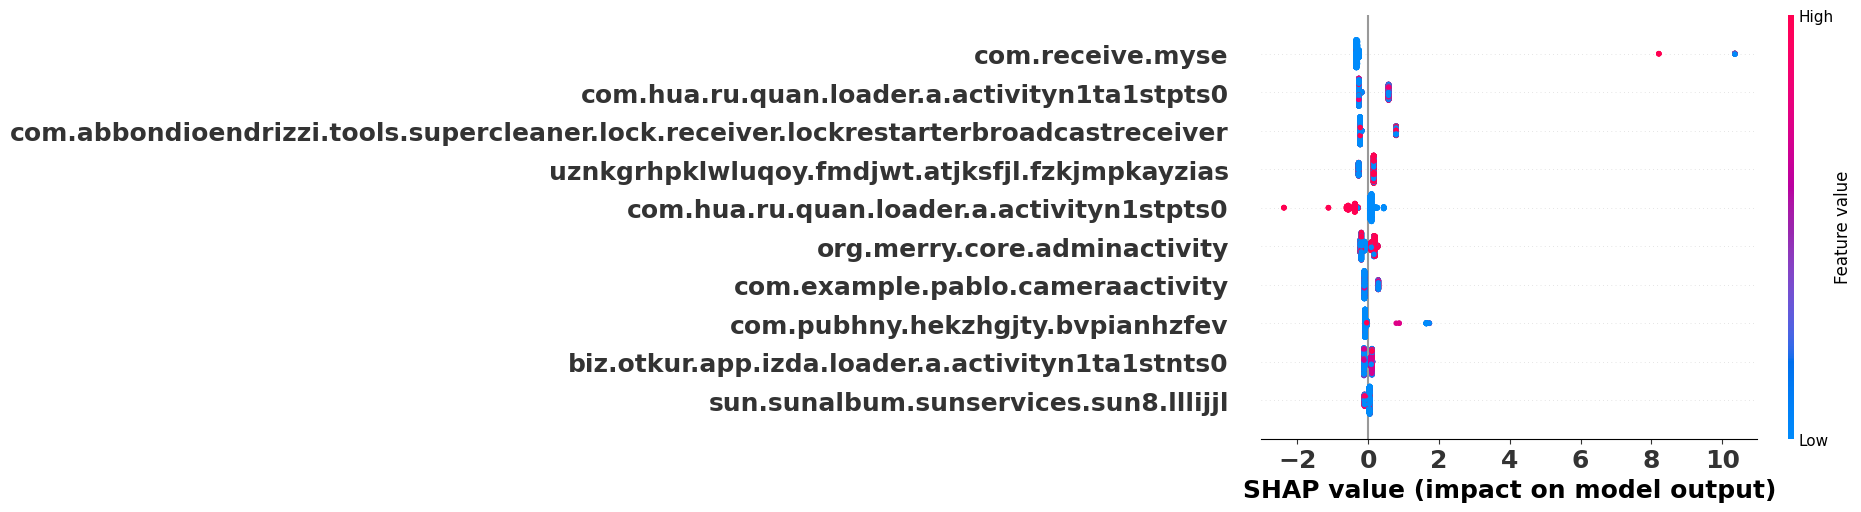

SHAP summary plot for label Command and control


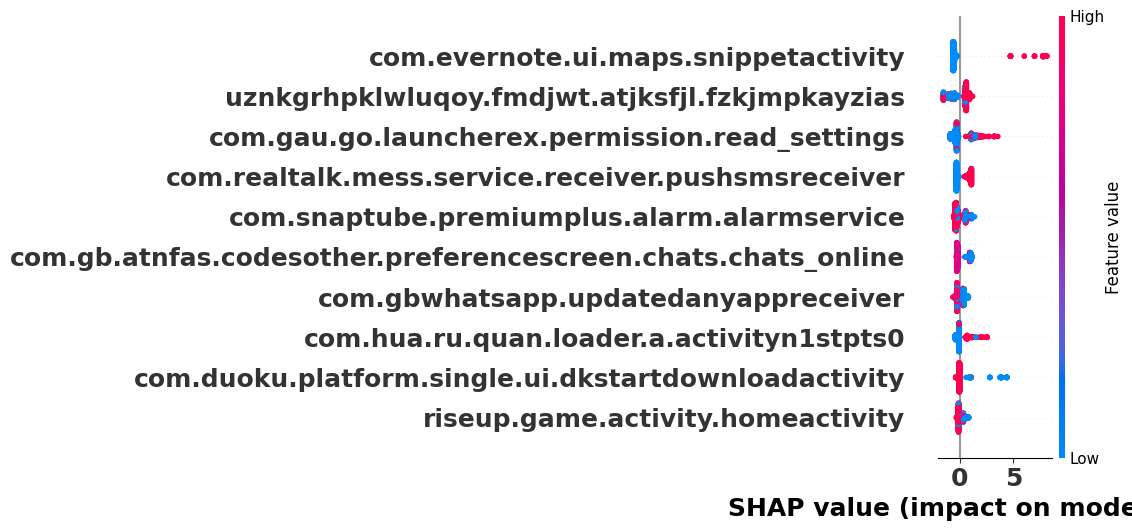

SHAP summary plot for label Collection


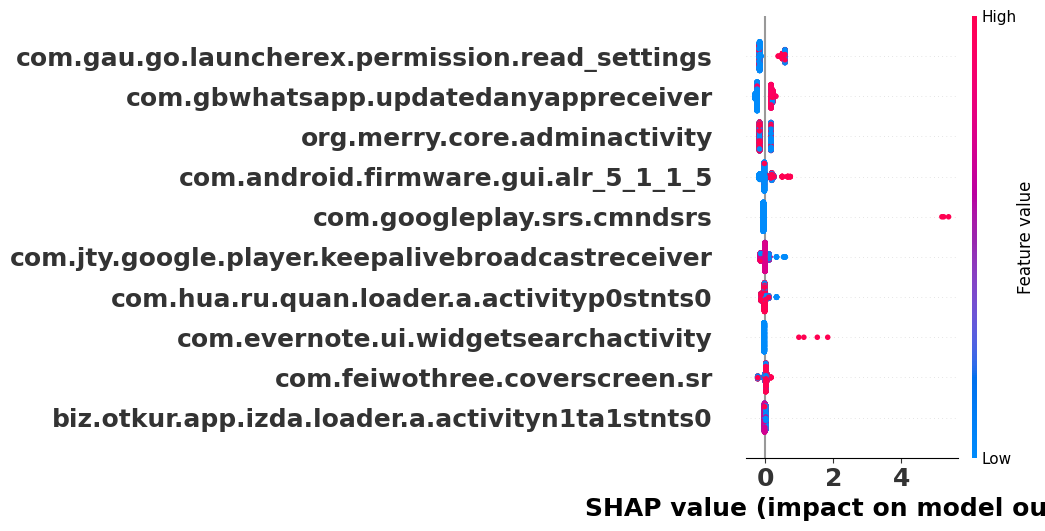

SHAP summary plot for label Impact


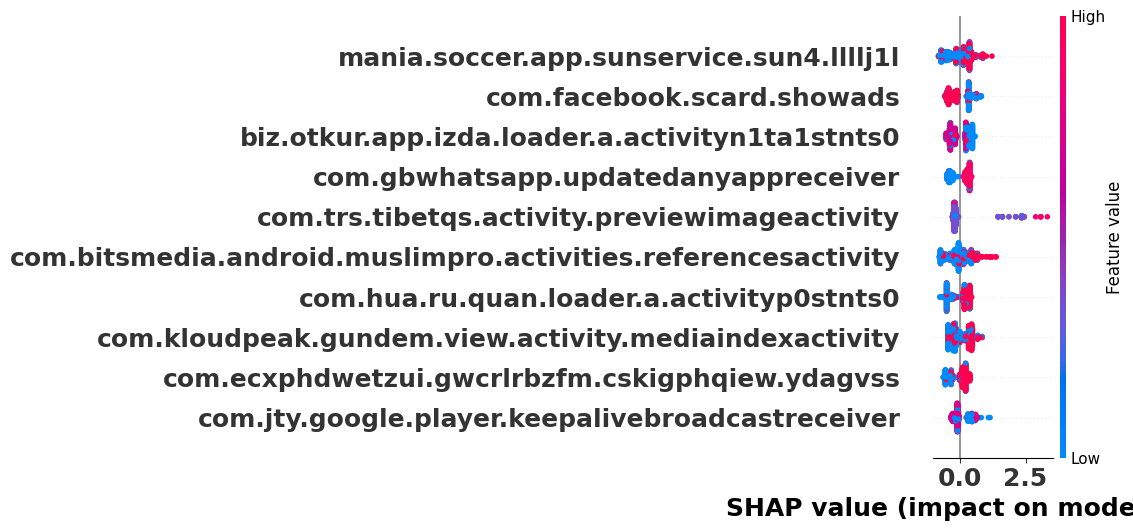

In [52]:
import matplotlib.pyplot as plt  # Import matplotlib for plotting
# Plot SHAP summary plot for each label separately
for i in range(len(label_names)):
    print(f"SHAP summary plot for label {label_names[i]}")

    # Extract SHAP values for the current label
    shap_values_label = shap_values[:, :, i]  # Select SHAP values corresponding to the i-th label

    # Plot the SHAP summary plot for this label
    shap.summary_plot(shap_values_label, X_test_selected, feature_names=X.columns.tolist(), show=False, max_display=10)

    # Increase the font size of x-ticks and y-ticks and make them bold
    plt.xticks(fontsize=18, fontweight='bold')  # Adjust the font size and weight of x-ticks
    plt.yticks(fontsize=18, fontweight='bold')  # Adjust the font size and weight of y-ticks

    # Increase the font size of x-axis title and make it bold
    plt.xlabel(plt.gca().get_xlabel(), fontsize=18, fontweight='bold')

    plt.show()


